In [1]:
import os, json, math, time, random, sys
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from math import ceil
from tqdm.auto import tqdm

sys.path.append(str(Path.cwd().parents[0])) 
import KEYS

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Métricas
from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parent))
from metricas.metrics_client import getRelevance, getFactuality, getReadability

# Reproducibilidad
def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", DEVICE)

# Prompts (usa los mismos que en entrenamiento)
SYSTEM_PROMPT = (
    "You simplify clinical trial protocol text into a plain-language summary for the general public. "
    "Keep to 6–8th grade readability, avoid diagnoses and speculation, no hallucinations, "
    "and preserve key facts (objective, population, interventions, outcomes, timelines, safety)."
)
USER_PREFIX = "Using the following clinical trial protocol text as input, create a plain language summary.\n\n"

d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device:  cuda


In [2]:
def load_model_and_tokenizer(model_dir: str, device: str = DEVICE):
    model_dir = str(Path(model_dir).resolve())
    cfg_path = Path(model_dir) / "adapter_config.json"
    if not cfg_path.exists():
        raise FileNotFoundError(f"No existe {cfg_path}")

    with open(cfg_path, "r", encoding="utf-8") as f:
        adapter_cfg = json.load(f)
    base = adapter_cfg.get("base_model_name_or_path")
    if not base:
        raise ValueError("adapter_config.json no contiene 'base_model_name_or_path'.")

    # Tokenizer desde el directorio del adapter (incluye el token extra)
    tok = AutoTokenizer.from_pretrained(model_dir, use_fast=True, trust_remote_code=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    tok.padding_side = "left"

    # Modelo base
    base_model = AutoModelForCausalLM.from_pretrained(
        base,
        torch_dtype=torch.float16 if device.startswith("cuda") else torch.float32,
        trust_remote_code=True
    ).to(device)

    #  alinear tamaño de vocab del base al del tokenizer usado en el adapter
    base_model.resize_token_embeddings(len(tok))

    # Cargar adapters LoRA
    model = PeftModel.from_pretrained(base_model, model_dir)
    model.eval()
    model.config.pad_token_id = tok.pad_token_id

    # token de fin de oración personalizado
    eos_id = None
    try:
        eid = tok.convert_tokens_to_ids("<|sentence_end|>")
        if eid is not None and eid != tok.unk_token_id:
            eos_id = eid
    except Exception:
        pass

    return model, tok, eos_id

In [3]:
# === Parámetros de evaluación ===
MODEL_DIR = "Qwen/outputs/Qwen__Qwen2.5-3B-Instruct-FKGD8_enfasis_fuerte/final"
DATASET_CSV = "../data/pls_abstract_pairs_with_metrics.csv"
SPLIT = "test"                  # 'test' o 'train'
NUM_EXAMPLES = 50               # cuántos ejemplos del split
SAMPLES_PER_EXAMPLE = 3         # cuántos resúmenes por ejemplo

SEED = 44
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# generación 
GEN_CFG = dict(
    max_new_tokens=2048,
    do_sample=True,
    temperature=0.2,
    top_p=0.95,
    no_repeat_ngram_size=3,
    repetition_penalty=1.05,
)

# Parametros de ventana deslizante
WINDOW_TOKENS = 512
OVERLAP_TOKENS = 128    # solape entre ventanas

# batches
BATCH_GEN = 2           # prompts por batch para generate()
BATCH_METRICS = 4       # micro-lote por POST a la API de métricas

# servicio de métricas
METRICS_URL = "http://127.0.0.1:8000" # corriendo en local

# salida
OUT_DIR = "GENERATED_TEXTS" 
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

set_seed(SEED)

model, tokenizer, EOS_ID = load_model_and_tokenizer(MODEL_DIR, DEVICE)
print("EOS_ID (custom):", EOS_ID)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


EOS_ID (custom): 151665


In [4]:
# === utilidades de sliding window (ENTRADA) ===
def _template_tokens_cost() -> int:
    # mide tokens de template con un dummy corto
    dummy = "X"
    prompt = tokenizer.apply_chat_template(
        [{"role":"system","content":SYSTEM_PROMPT},
         {"role":"user","content":USER_PREFIX + dummy}],
        tokenize=False, add_generation_prompt=True
    )
    return len(tokenizer(prompt, add_special_tokens=False).input_ids)

def windowize_source(text: str, window_tokens: int, overlap_tokens: int) -> List[str]:
    ids = tokenizer(text, add_special_tokens=False).input_ids
    if len(ids) <= window_tokens:
        return [text]
    windows, step = [], max(1, window_tokens - overlap_tokens)
    for start in range(0, len(ids), step):
        end = min(start + window_tokens, len(ids))
        chunk = tokenizer.decode(ids[start:end], skip_special_tokens=True).strip()
        if chunk:
            windows.append(chunk)
        if end == len(ids):
            break
    return windows

def build_prompt(src: str) -> str:
    return tokenizer.apply_chat_template(
        [{"role":"system","content":SYSTEM_PROMPT},
         {"role":"user","content":USER_PREFIX + str(src)}],
        tokenize=False, add_generation_prompt=True
    )

In [5]:
# generación con ventana deslizante en ENTRADA y fusión de parciales ===
@torch.no_grad()
def generate_samples(sliding_sources: List[List[str]], n_samples: int) -> List[List[str]]:
    """
    `sliding_sources`: lista de documentos; cada documento es una lista de ventanas de *source* (texto).
    Retorna: lista de documentos; cada doc es lista de 'n_samples' salidas (cada salida es fusión de parciales).
    """
    all_doc_outputs = [list() for _ in range(len(sliding_sources))]
    base_cfg = GEN_CFG.copy()
    # Usar ambos EOS si existe custom
    if EOS_ID is not None:
        base_cfg["eos_token_id"] = [tokenizer.eos_token_id, EOS_ID]
    else:
        base_cfg["eos_token_id"] = tokenizer.eos_token_id
    base_cfg["pad_token_id"] = tokenizer.pad_token_id

    # Para mostrar progreso: nº de rondas × nº de docs × nº de lotes por doc (aprox por ventanas)
    total_windows = sum(len(wins) for wins in sliding_sources)
    approx_batches_per_round = ceil(total_windows / max(1, BATCH_GEN))
    pbar = tqdm(total=n_samples * approx_batches_per_round, desc="Generando : ", unit="batch")

    for _ in range(n_samples):
        # generamos documento por documento para poder fusionar ventanas
        for doc_idx, wins in enumerate(sliding_sources):
            if not wins:
                all_doc_outputs[doc_idx].append("")  # doc vacío
                continue

            # construir prompts por ventana
            prompts = [build_prompt(w) for w in wins]

            # generar por lotes de ventanas
            partials = []
            for i in range(0, len(prompts), BATCH_GEN):
                j = min(i + BATCH_GEN, len(prompts))
                batch_prompts = prompts[i:j]
                inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
                gen = model.generate(**inputs, **base_cfg)
                cut = inputs["input_ids"].shape[1]
                outs = tokenizer.batch_decode(gen[:, cut:], skip_special_tokens=True)
                partials.extend([o.strip() for o in outs])
                pbar.update(1)

            # fusión (idéntica a lo discutido en entrenamiento: concatenación simple)
            fused = "\n".join(p for p in partials if p)
            all_doc_outputs[doc_idx].append(fused)

    pbar.close()
    return all_doc_outputs

In [6]:
df = pd.read_csv(DATASET_CSV)
cols = {"source_text","target_text","split"}
if not cols.issubset(df.columns):
    raise ValueError(f"El CSV debe contener {cols}")

val_df = df[df["split"] == SPLIT].dropna(subset=["source_text","target_text"]).reset_index(drop=True)
if len(val_df) == 0:
    raise ValueError(f"No hay filas para split='{SPLIT}'")
if NUM_EXAMPLES < len(val_df):
    val_df = val_df.sample(n=NUM_EXAMPLES, random_state=SEED).reset_index(drop=True)

sources = val_df["source_text"].tolist()
targets = val_df["target_text"].tolist()

# Crear ventanas por documento (
sliding_sources = [windowize_source(src, WINDOW_TOKENS, OVERLAP_TOKENS) for src in sources]

generated = generate_samples(sliding_sources, SAMPLES_PER_EXAMPLE)


Generando : : 240batch [2:03:30, 30.88s/batch]                      


In [7]:
assert len(generated) == len(sliding_sources)
assert all(len(xs) == SAMPLES_PER_EXAMPLE for xs in generated)

=== Estadísticas globales ===

RELEVANCE: n=150
  mean=0.8364  std=0.0106  min=0.8075  p25=0.8299  p50=0.8369  p75=0.8442  max=0.8618

FACTUALITY: n=150
  mean=0.3052  std=0.0603  min=0.1674  p25=0.2655  p50=0.3077  p75=0.3434  max=0.5105

FKGL: n=150
  mean=10.8327  std=1.4402  min=7.2454  p25=9.7865  p50=10.7577  p75=11.9199  max=14.6107

SMOG: n=150
  mean=13.0619  std=1.1217  min=9.9950  p25=12.3184  p50=13.0310  p75=13.8693  max=16.4588

DALE_CHALL: n=150
  mean=11.2399  std=0.8734  min=8.5306  p25=10.6197  p50=11.1898  p75=11.7334  max=15.2908


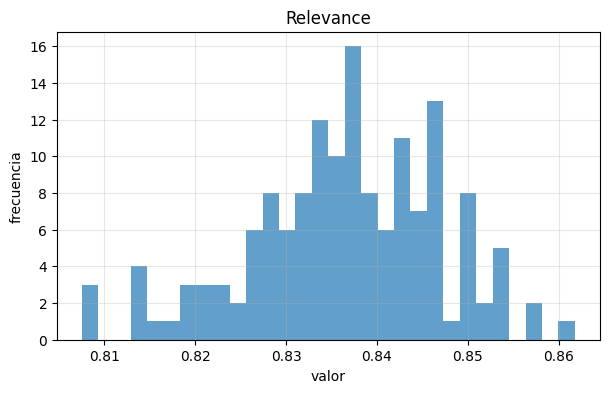

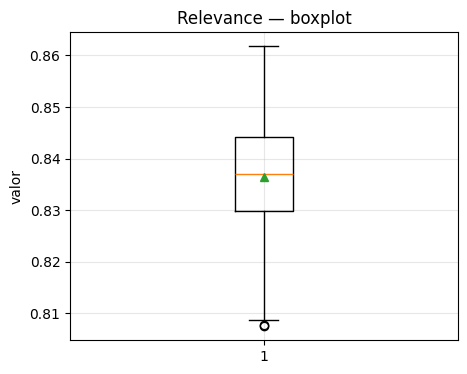

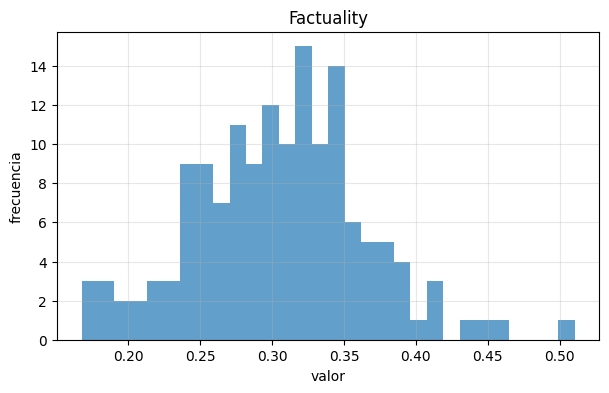

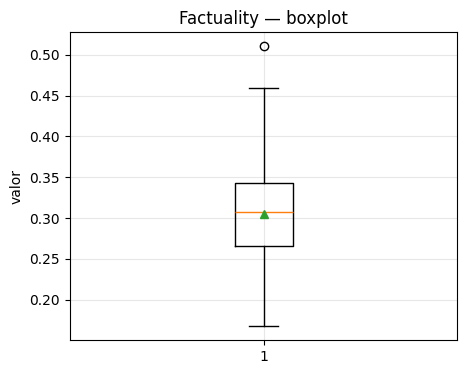

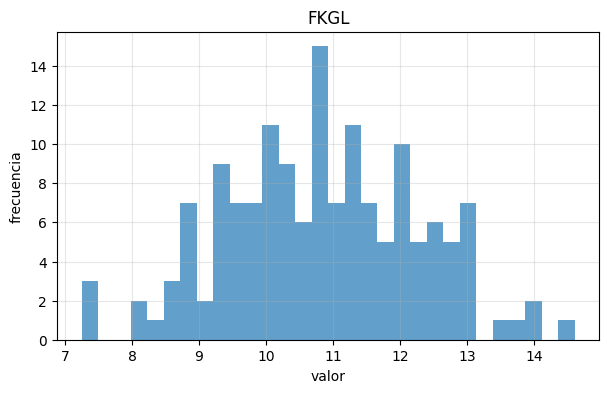

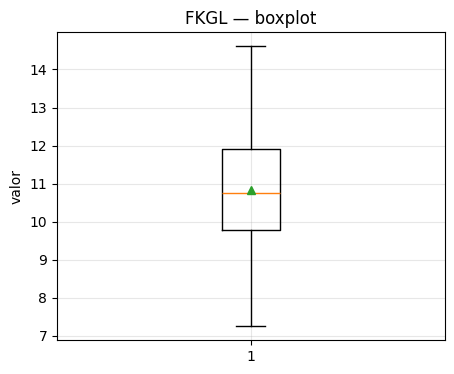

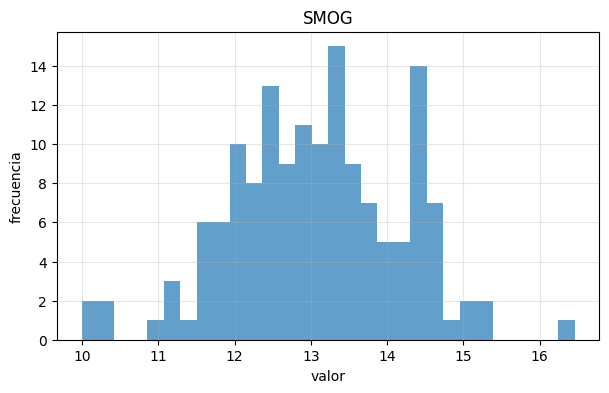

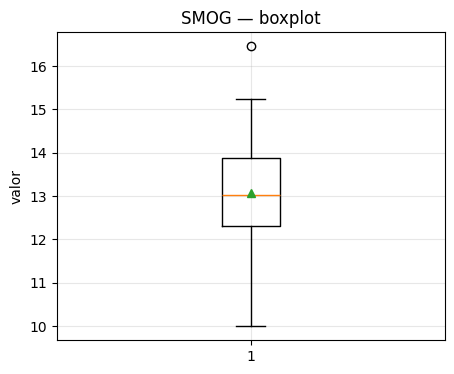

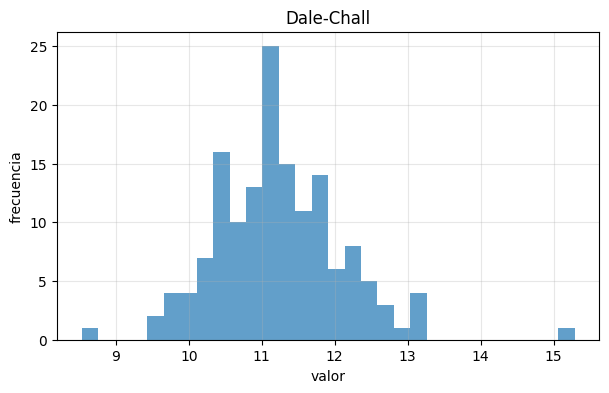

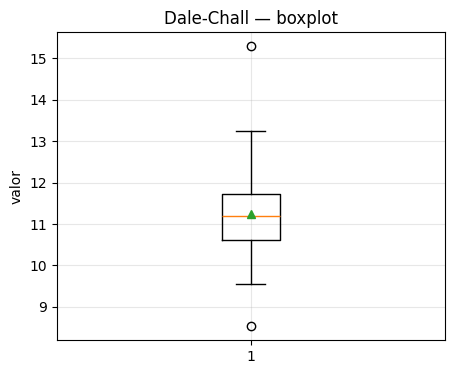

In [8]:
def chunked(iterable, n):
    for i in range(0, len(iterable), n):
        yield iterable[i:i+n]

rows = []  # filas por ejemplo×muestra
for doc_id, (src, tgt, gens) in enumerate(zip(sources, targets, generated)):
    # evaluamos por micro-lotes contra la API
    pairs_src, pairs_gen = [], []
    for sidx, gen_txt in enumerate(gens):
        pairs_src.append(src)          # siempre contra el documento completo
        pairs_gen.append(gen_txt)      # salida final fusionada

    # relevance
    rel_scores = []
    for c_src, c_gen in zip(chunked(pairs_src, BATCH_METRICS), chunked(pairs_gen, BATCH_METRICS)):
        rel_scores.extend(getRelevance(c_src, c_gen, base_url=METRICS_URL, timeout=180.0))

    # factuality
    fac_scores = []
    for c_src, c_gen in zip(chunked(pairs_src, BATCH_METRICS), chunked(pairs_gen, BATCH_METRICS)):
        fac_scores.extend(getFactuality(c_src, c_gen, base_url=METRICS_URL, timeout=900.0))

    # readability (solo sobre generados)
    fkgl_all, smog_all, dale_all = [], [], []
    for c_gen in chunked(pairs_gen, BATCH_METRICS):
        rd = getReadability(c_gen, base_url=METRICS_URL, timeout=180.0)
        fkgl_all.extend(rd["fkgl"]); smog_all.extend(rd["smog"]); dale_all.extend(rd["dale_chall"])

    # registrar filas
    for sidx in range(len(gens)):
        rows.append({
            "doc_id": doc_id,
            "sample_idx": sidx,
            "relevance": float(rel_scores[sidx]),
            "factuality": float(fac_scores[sidx]),
            "fkgl": float(fkgl_all[sidx]),
            "smog": float(smog_all[sidx]),
            "dale_chall": float(dale_all[sidx]),
        })

per_sample_df = pd.DataFrame(rows).sort_values(["doc_id","sample_idx"]).reset_index(drop=True)
per_sample_df.head(), per_sample_df.shape

def summarize_series(x: pd.Series) -> Dict[str, float]:
    v = x.dropna().to_numpy()
    if v.size == 0:
        return {"mean": None,"std": None,"min": None,"max": None,"p25": None,"p50": None,"p75": None,"n": 0}
    return {
        "mean": float(np.mean(v)),
        "std":  float(np.std(v, ddof=1)) if v.size > 1 else 0.0,
        "min":  float(np.min(v)),
        "max":  float(np.max(v)),
        "p25":  float(np.percentile(v, 25)),
        "p50":  float(np.percentile(v, 50)),
        "p75":  float(np.percentile(v, 75)),
        "n":    int(v.size),
    }

# Agregación global
stats = {
    "relevance":   summarize_series(per_sample_df["relevance"]),
    "factuality":  summarize_series(per_sample_df["factuality"]),
    "fkgl":        summarize_series(per_sample_df["fkgl"]),
    "smog":        summarize_series(per_sample_df["smog"]),
    "dale_chall":  summarize_series(per_sample_df["dale_chall"]),
}

# Imprimir estadísticas
print("=== Estadísticas globales ===")
for k, s in stats.items():
    print(f"\n{k.upper()}: n={s['n']}")
    print(f"  mean={s['mean']:.4f}  std={s['std']:.4f}  min={s['min']:.4f}  p25={s['p25']:.4f}  p50={s['p50']:.4f}  p75={s['p75']:.4f}  max={s['max']:.4f}")

# Graficar (una figura por métrica)
def plot_distribution(series: pd.Series, title: str):
    v = series.dropna().to_numpy()
    if v.size == 0:
        print(f"[skip] {title}: sin datos")
        return
    plt.figure(figsize=(7,4))
    plt.hist(v, bins=30, alpha=0.7)
    plt.title(title); plt.xlabel("valor"); plt.ylabel("frecuencia"); plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(5,4))
    plt.boxplot(v, vert=True, showmeans=True)
    plt.title(f"{title} — boxplot"); plt.ylabel("valor"); plt.grid(alpha=0.3)
    plt.show()

plot_distribution(per_sample_df["relevance"],  "Relevance")
plot_distribution(per_sample_df["factuality"], "Factuality")
plot_distribution(per_sample_df["fkgl"],       "FKGL")
plot_distribution(per_sample_df["smog"],       "SMOG")
plot_distribution(per_sample_df["dale_chall"], "Dale-Chall")

In [9]:
# Guardar generacion en CSV: primera columna = source_text, siguientes = gen_1..gen_N
from pathlib import Path
import os
import pandas as pd

SAFE_MODEL_NAME = str(MODEL_DIR).replace(os.sep, "__").replace("/", "__").replace(" ", "_")
cols = ["source_text"] + [f"gen_{i+1}" for i in range(SAMPLES_PER_EXAMPLE)]
rows = []

for src, gens in zip(sources, generated):
    # `generated` es una lista de listas con SAMPLES_PER_EXAMPLE textos por fila
    row = [src] + gens
    rows.append(row)

df_out = pd.DataFrame(rows, columns=cols)
out_path = Path(OUT_DIR) / f"{SAFE_MODEL_NAME}_generations.csv"
df_out.to_csv(out_path, index=False, encoding="utf-8")
print(f"[saved] {out_path}")


[saved] GENERATED_TEXTS\Qwen__outputs__Qwen__Qwen2.5-3B-Instruct-FKGD8_enfasis_fuerte__final_generations.csv


In [10]:
# === MLflow (sin cambios, excepto que loguea lo generado tras sliding) ===
import mlflow
from datetime import datetime
from mlflow.data import from_pandas

os.environ["DATABRICKS_HOST"] = KEYS.DATABRICKS_HOST
os.environ["DATABRICKS_TOKEN"] = KEYS.DATABRICKS_TOKEN
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/GeneracionDeResumenes/Estadísticas_de_Modelos")

RUN_OUT = Path(OUT_DIR) / "mlflow_artifacts"
PLOTS_DIR = RUN_OUT / "plots"
RUN_OUT.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def save_distribution(series: pd.Series, title: str, slug: str):
    v = series.dropna().to_numpy()
    if v.size == 0:
        return
    plt.figure(figsize=(7,4))
    plt.hist(v, bins=30, alpha=0.7)
    plt.title(title); plt.xlabel("valor"); plt.ylabel("frecuencia"); plt.grid(alpha=0.3)
    hist_path = PLOTS_DIR / f"{slug}_hist.png"
    plt.savefig(hist_path, bbox_inches="tight"); plt.close()

    plt.figure(figsize=(5,4))
    plt.boxplot(v, vert=True, showmeans=True)
    plt.title(f"{title} — boxplot"); plt.ylabel("valor"); plt.grid(alpha=0.3)
    box_path = PLOTS_DIR / f"{slug}_box.png"
    plt.savefig(box_path, bbox_inches="tight"); plt.close()

save_distribution(per_sample_df["relevance"],  "Relevance",   "relevance")
save_distribution(per_sample_df["factuality"], "Factuality",  "factuality")
save_distribution(per_sample_df["fkgl"],       "FKGL",        "fkgl")
save_distribution(per_sample_df["smog"],       "SMOG",        "smog")
save_distribution(per_sample_df["dale_chall"], "Dale-Chall",  "dale_chall")

# per_sample_csv = RUN_OUT / "per_sample_metrics.csv"
# per_sample_df.to_csv(per_sample_csv, index=False)

stats_json_path = RUN_OUT / "aggregate_stats.json"
with open(stats_json_path, "w", encoding="utf-8") as f:
    json.dump(stats, f, ensure_ascii=False, indent=2)

SAFE_MODEL_NAME = str(MODEL_DIR).replace(os.sep, "__").replace("/", "__").replace(" ", "_")
run_name = f"{SAFE_MODEL_NAME}-eval-{datetime.now().strftime('%Y%m%d_%H%M%S')}"

mlflow.end_run()
with mlflow.start_run(run_name=run_name):
    try:
        ds_val = from_pandas(val_df, source="PLS_pairs", name=f"PLS_{SPLIT}")
        mlflow.log_input(ds_val, context="validation")
    except Exception as e:
        print("[MLflow] Aviso: no pude registrar dataset de validación:", e)

    mlflow.log_params({
        "model_dir": SAFE_MODEL_NAME,
        "device": DEVICE,
        "split": SPLIT,
        "num_examples": NUM_EXAMPLES,
        "samples_per_example": SAMPLES_PER_EXAMPLE,
        "System Prompt": SYSTEM_PROMPT,
        "User_Prefix": USER_PREFIX,
        **{f"gen_{k}": v for k, v in GEN_CFG.items()},
        "window_tokens": WINDOW_TOKENS,
        "overlap_tokens": OVERLAP_TOKENS,
        "fusion_mode": "concat",
    })

    mlflow.set_tag(
        "mlflow.note.content",
        f"Evaluación con Sliding Window en ENTRADA (concat parciales) — split={SPLIT}. "
        f"{SAMPLES_PER_EXAMPLE} muestras/doc. GenCfg={GEN_CFG}"
    )

    def log_agg(prefix: str, d: dict):
        clean = {k: float(v) for k, v in d.items() if isinstance(v, (int, float))}
        mlflow.log_metrics({f"{prefix}_{k}": v for k, v in clean.items()})
        if "n" in d: mlflow.log_metric(f"{prefix}_n", int(d["n"]))
    for m in ("relevance","factuality","fkgl","smog","dale_chall"):
        log_agg(m, stats[m])

    
    mlflow.log_artifact(str(stats_json_path), artifact_path="metrics")
    for p in PLOTS_DIR.glob("*.png"):
        mlflow.log_artifact(str(p), artifact_path="plots")

    adapter_cfg = Path(MODEL_DIR) / "adapter_config.json"
    if adapter_cfg.exists():
        mlflow.log_artifact(str(adapter_cfg), artifact_path="model_info")

    from datetime import datetime as _dt
    mlflow.set_tag("finished_at", _dt.utcnow().isoformat() + "Z")

print("MLflow: evaluación registrada. Tracking URI:", mlflow.get_tracking_uri())

d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'PLS_pairs'. Exception: 
  return _dataset_source_registry.resolve(
d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integ

🏃 View run Qwen__outputs__Qwen__Qwen2.5-3B-Instruct-FKGD8_enfasis_fuerte__final-eval-20251112_020147 at: https://dbc-2d843358-2bd3.cloud.databricks.com/ml/experiments/2155265131954813/runs/01c580474b71415689f0f75bffd628ce
🧪 View experiment at: https://dbc-2d843358-2bd3.cloud.databricks.com/ml/experiments/2155265131954813
MLflow: evaluación registrada. Tracking URI: databricks


In [11]:
from IPython.display import Markdown
def export_code_cells():
    from IPython import get_ipython
    cells = get_ipython().user_ns['In']
    code = '\n\n'.join([c for c in cells if c.strip()])
    return Markdown(f'```python\n{code}\n```')
#export_code_cells()